# Calculate wilting point volumetric water content
corresponding to the one used in the irrigation module

see CLM5.0 user guide page 86

In [32]:
import os

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import regionmask


# import own utils module
from iv_utils_daint import *

from ctsm_py.utils import *

# do plotting settings
set_plot_param()

# directory settings
procdir =  outdir + 'processing_4p1000/' 

# scenarions
scenarios = ['4p1000', 'medium', 'high']

In [53]:
# define constants

psi_wilt = -150000 # wilting point matrix potential (mm) vegetation soil suction

psi_om = -10.33 # mm satureated organic water potential

psi_target = -3400 # see table 26.4

theta_om = 0.9 # porosity organic matter

Bom = 2.7

rho_organic_max = 130 # from CLM parameter file 


In [34]:
# Load input data

inputdir = procdir+'surfdata_4p1000/'
surfat_filename = 'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_CTL.nc'
ds_input = xr.open_dataset(inputdir+surfat_filename)

In [35]:
# load spatial constants from input data
rho_organic = ds_input['ORGANIC']
# fraction organic matter
fom = rho_organic / rho_organic_max
pct_clay = ds_input['PCT_SAND']
pct_sand = ds_input['PCT_CLAY']
landmask = ds_input['LANDFRAC_PFT']

In [36]:
# Do calculations

# theta sat
theta_sat_min = 0.489-0.00126*pct_sand
theta_sat = (1-fom) * theta_sat_min + fom*theta_om

# PSI sat
psi_sat_min = -10*10**(1.88-0.0131*pct_sand)

psi_sat = (1-fom) * psi_sat_min + fom*psi_om


# Exponent B
Bmin = 2.91+0.159*pct_clay

B = (1-fom) * Bmin + fom * Bom


# theta_wilt
theta_wilt = theta_sat * ((psi_wilt)/psi_sat)**(-1/B)
theta_wilt = theta_wilt.where(landmask)


## make independent check by comparing theta sat with the modelled watsat

In [38]:
# case settings
case_ctl = 'I2000Clm51Sp.hcru_hcru_mt13.CTL'
# I2000Clm51Sp.hcru_hcru_mt13.4p1000_CTL_pft.20230712-1723

case = case_ctl
block = "lnd"
stream = "h0"

variables = ["watsat", "H2OSOI" ]

start_year = 2004
end_year = 2004

time_slice = slice(str(start_year) + "-01-01", str(end_year) + "-12-01")

ds = import_case(case_ctl, myVars=variables, timeSlice=time_slice,  alter_lons=False)
da_watsat = ds['watsat']

In [40]:
theta_wilt= theta_wilt.assign_coords(lsmlat= (da_watsat.lat.values)).assign_coords(lsmlon= (da_watsat.lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat', 'nlevsoi':'levsoi'})

theta_wilt = lon_pm2idl(theta_wilt, fail_silently=False)


In [42]:
ds = theta_wilt.to_dataset(name='H2OSOI_WILT')
os.system('rm /scratch/snx3000/ivanderk/processing_4p1000/postprocessing/wilting_volumetric_soil_water_CTL.nc')
ds.to_netcdf(procdir + 'postprocessing/wilting_volumetric_soil_water_CTL.nc')


## make independent check by comparing theta sat with the modelled watsat

In [43]:
theta_sat = theta_sat.assign_coords(lsmlat= (da_watsat.lat.values)).assign_coords(lsmlon= (da_watsat.lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat', 'nlevsoi':'levsoi'})


In [44]:
# theta_sat is negative 

diff = theta_sat - da_watsat.rename({'levgrnd':'levsoi'})[-1,:10,:,:]

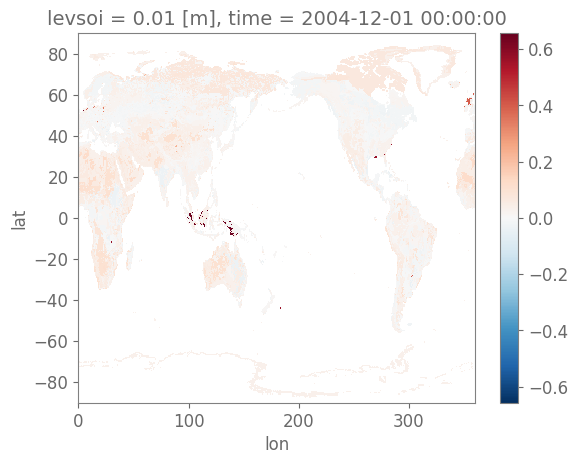

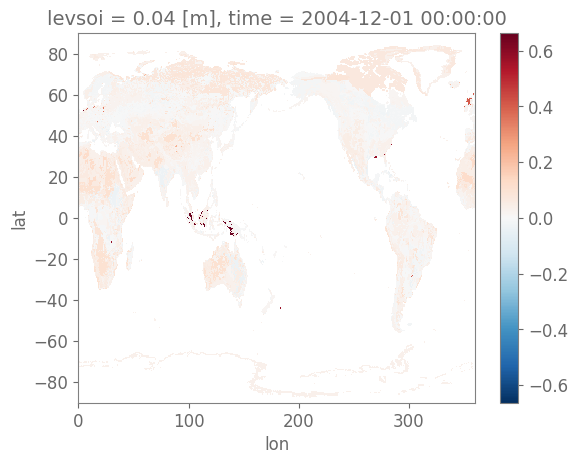

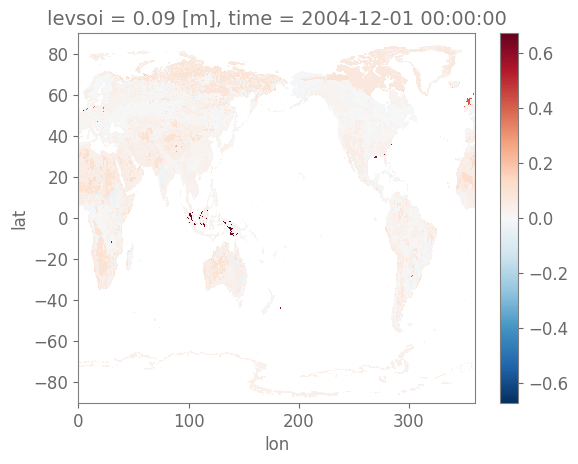

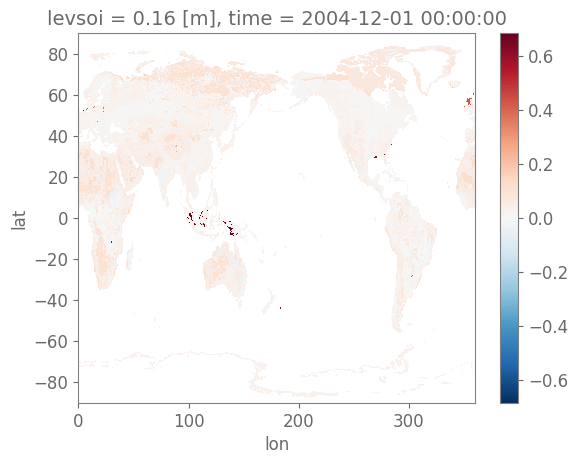

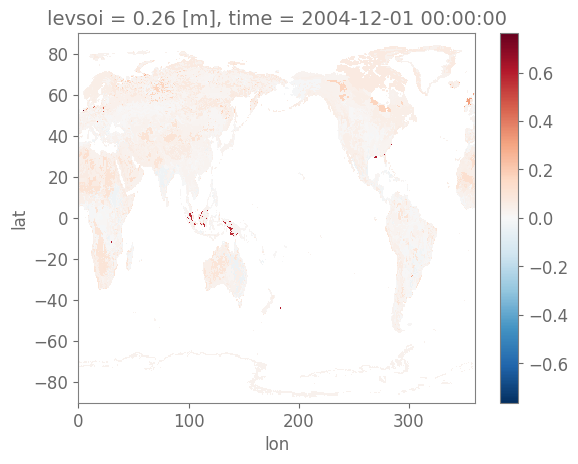

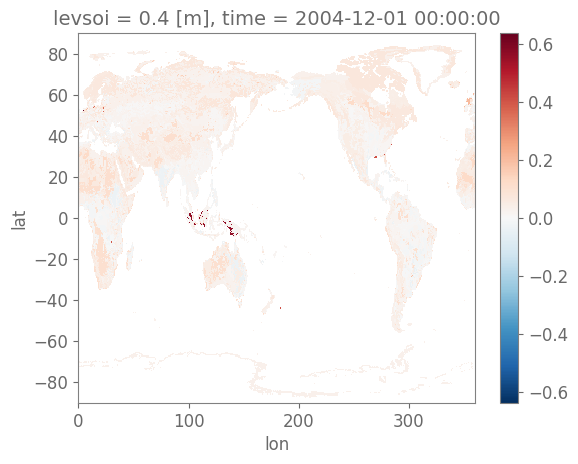

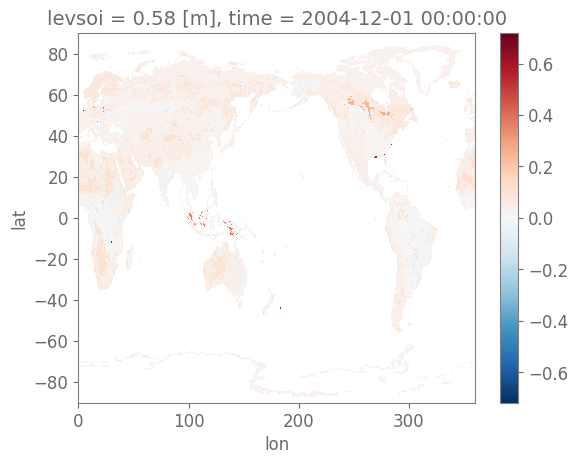

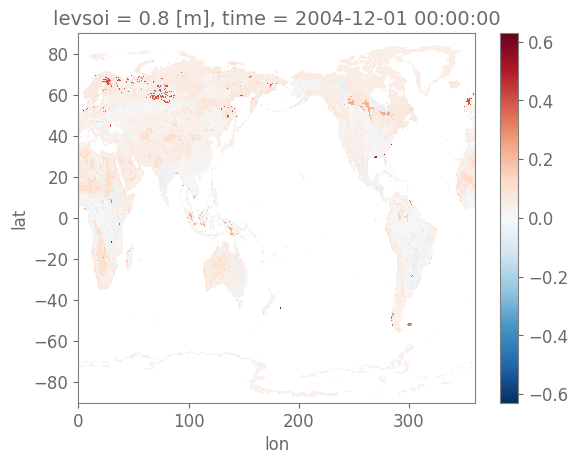

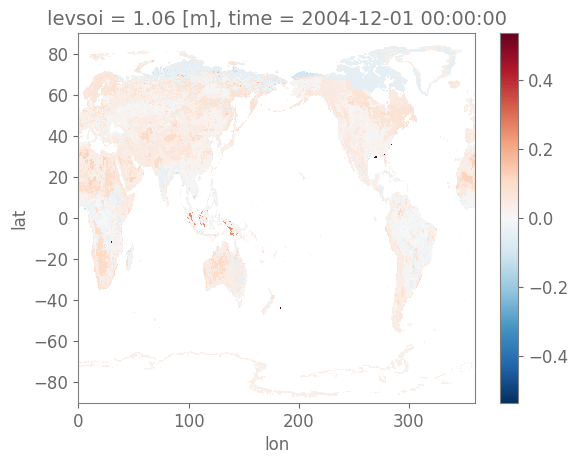

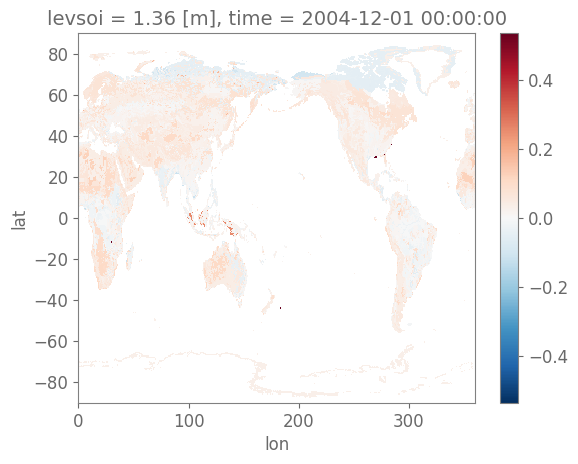

In [45]:
for i in range(0,10): 
    fig,ay = plt.subplots()
    diff[i,:,:].plot(ax=ay)

## Calculate wilting point for different scenarios

In [50]:
# Load input data
inputdir = procdir+'surfdata_4p1000/'

for scenario in scenarios: 
    surfat_filename = 'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc'
    ds_input = xr.open_dataset(inputdir+surfat_filename)
    
    # load spatial constants from input data
    rho_organic = ds_input['ORGANIC']
    # fraction organic matter
    fom = rho_organic / rho_organic_max
    pct_clay = ds_input['PCT_SAND']
    pct_sand = ds_input['PCT_CLAY']
    landmask = ds_input['LANDFRAC_PFT']
    
    # to calculate

    # theta sat
    theta_sat_min = 0.489-0.00126*pct_sand
    theta_sat = (1-fom) * theta_sat_min + fom*theta_om

    # PSI sat
    psi_sat_min = -10*10**(1.88-0.0131*pct_sand)

    psi_sat = (1-fom) * psi_sat_min + fom*psi_om


    # Exponent B
    Bmin = 2.91+0.159*pct_clay

    B = (1-fom) * Bmin + fom * Bom


    # theta_wilt
    theta_wilt = theta_sat * ((psi_wilt)/psi_sat)**(-1/B)
    theta_wilt = theta_wilt.where(landmask)

    theta_wilt= theta_wilt.assign_coords(lsmlat= (da_watsat.lat.values)).assign_coords(lsmlon= (da_watsat.lon).values).rename({'lsmlon':'lon', 'lsmlat':'lat', 'nlevsoi':'levsoi'})
    theta_wilt = lon_pm2idl(theta_wilt, fail_silently=False)

    ds = theta_wilt.to_dataset(name='H2OSOI_WILT')
    ds.to_netcdf(procdir + 'postprocessing/wilting_volumetric_soil_water_'+scenario+'.nc')


## Calculate irrigation threshold for different scenarios

see CLM documentation formula 26.13 and further

In [51]:
scenarios = ['4p1000', 'CTL']

In [52]:
# Load input data
inputdir = procdir+'surfdata_4p1000/'

for scenario in scenarios: 
    surfat_filename = 'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc'
    ds_input = xr.open_dataset(inputdir+surfat_filename)
    
    # load spatial constants from input data
    rho_organic = ds_input['ORGANIC']
    # fraction organic matter
    fom = rho_organic / rho_organic_max
    pct_clay = ds_input['PCT_SAND']
    pct_sand = ds_input['PCT_CLAY']
    landmask = ds_input['LANDFRAC_PFT']
    
    # to calculate

    # theta sat
    theta_sat_min = 0.489-0.00126*pct_sand
    theta_sat = (1-fom) * theta_sat_min + fom*theta_om

    # PSI sat
    psi_sat_min = -10*10**(1.88-0.0131*pct_sand)

    psi_sat = (1-fom) * psi_sat_min + fom*psi_om


    # Exponent B
    Bmin = 2.91+0.159*pct_clay

    B = (1-fom) * Bmin + fom * Bom


    # theta_wilt
    theta_wilt = theta_sat * ((psi_wilt)/psi_sat)**(-1/B)
    theta_wilt = theta_wilt.where(landmask)
    
    
    # theta_target
    theta_target = theta_sat * ((psi_target)/psi_sat)**(-1/B)
    theta_target = theta_target.where(landmask)

    # theta_threshold
    theta_thresold = theta_wilt + (theta_target - theta_wilt)

    theta_thresold= theta_thresold.assign_coords(lsmlat= (da_watsat.lat.values)).assign_coords(lsmlon= (da_watsat.lon).values).rename({'lsmlon':'lon', 'lsmlat':'lat', 'nlevsoi':'levsoi'})
    theta_thresold = lon_pm2idl(theta_thresold, fail_silently=False)

    ds = theta_thresold.to_dataset(name='H2OSOI_THRESH')
    ds.to_netcdf(procdir + 'postprocessing/wilting_volumetric_soil_water_'+scenario+'_threshold.nc')


In [ ]:
theta_thresold.mean('levsoi').plot() 

In [ ]:
(theta_wilt).mean('levsoi').plot() 

In [ ]:
(theta_thresold - theta_wilt).mean('levsoi').plot() 

In [ ]:
theta_wilt = theta_wilt.assign_coords(lsmlat= (da_watsat.lat.values)).assign_coords(lsmlon= (da_watsat.lon).values).rename({'lsmlon':'lon', 'lsmlat':'lat', 'nlevsoi':'levsoi'})

In [ ]:
(theta_target.mean('levsoi').plot() 